In [1]:

from numba.core.extending import get_cython_function_address
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import pytz
import pvlib

# directory with clean and organized data per year for GHI, GTI, DIF, DNI
main_path = "/Users/nataly/opt/AnacondaProjects/SAPIENS/CLEAN/" 

# directory to save BSRN test results
BSRN_path = "/Users/nataly/opt/AnacondaProjects/SAPIENS/BSRN/" 

ghi =  ['GHIP_SI02pt100',
        'GHIP_SMP11',
        'GHIP_SMP22',
        'GHIP_SPN1',
        'GHIT_SMP22']

fghi = ['F_GHIP_SI02pt100', 
        'F_GHIP_SMP11', 
        'F_GHIP_SMP22', 
        'F_GHIP_SPN1', 
        'F_GHIT_SMP22']

gti = ['TGHIP_SI02pt100', 
       'TGHIP_SI02pt100_dirty',
       'TGIP_SMP11_VENT']
      
dif = ['DfHIP_SPN1', 
       'DfHIRP_SMP11',
       'DfHIT_SMP22',
       'DIF_GLO_REF_SPN1']

fdif = ['F_DfHIP_SPN1', 
        'F_DfHIRP_SMP11', 
        'F_DfHIT_SMP22',
        'F_DIF_GLO_REF_SPN1']

dni = ['DNI_SHP1']

fdni = ['F_DNI_SHP1']

months = ['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
          '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
          '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
          '2021-01']

years = ['2018', '2019', '2020', '2021']

#BSRN TEST

# latitude, longitude, name, altitude, timezone - data retrieved in local time.
location = pvlib.location.Location(-27.430891, -48.441406, tz = 'Brazil/East', altitude= 2.74, name = 'Florianopolis')  # check for daylight savings 'Etc/GMT-3' 'America/Sao_Paulo'

missing = pd.DataFrame(columns= ['days'], index = years) # count data record missing in a year, for each year. IN THE DATALOGGER. individual sensor may have empty entries not accounted for

ghiFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin', fghi])

difFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin', fdif])  

dniFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin', fdni])

PPmin = -4  # minimum physically possible limit
ERmin = -2  # minimum extremely rare limit

flags = [-1, #NaN
         -1, #-9999   - apparently did not appear?!?! TEST: create specific flag to track it.
          3, # too low PP
          1, # too low ER
          2, # too high ER
          4] # too high PP

ghiflagcount = pd.DataFrame(columns= [ghi], index = [-1, 0, 1, 2, 3, 4], dtype = int) 
difflagcount = pd.DataFrame(columns= [dif], index = [-1, 0, 1, 2, 3, 4], dtype = int) 
dniflagcount = pd.DataFrame(columns= [dni], index = [-1, 0, 1, 2, 3, 4], dtype = int) 


#### end definitions

In [2]:
location = pvlib.location.Location(-27.430891, -48.441406, tz = 'Brazil/East', altitude= 2.74, name = 'Florianopolis')  # check for daylight savings 'Etc/GMT-3' 'America/Sao_Paulo'

missing = pd.DataFrame(columns= ['days'], index = years) # count data record missing in a year, for each year. IN THE DATALOGGER. individual sensor may have empty entries not accounted for

ghiFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin', fghi])

difFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin', fdif])  

dniFLAG = pd.DataFrame(columns = ['PPmax', 'PPmin', 'ERmax', 'ERmin', fdni])

PPmin = -4  # minimum physically possible limit
ERmin = -2  # minimum extremely rare limit

flags = [-1, #NaN
         -1, #-9999   - apparently did not appear?!?! TEST: create specific flag to track it.
          3, # too low PP
          1, # too low ER
          2, # too high ER
          4] # too high PP

ghiflagcount = pd.DataFrame(columns= [ghi], index = [-1, 0, 1, 2, 3, 4], dtype = int) 
difflagcount = pd.DataFrame(columns= [dif], index = [-1, 0, 1, 2, 3, 4], dtype = int) 
dniflagcount = pd.DataFrame(columns= [dni], index = [-1, 0, 1, 2, 3, 4], dtype = int) 


#### end definitions


In [3]:
year = years[0]

In [4]:
year

'2018'

In [5]:
dfghi = pd.read_pickle(main_path+year+'GHI.pkl')

In [6]:
dfghi.shape

(29806375, 5)

In [71]:
dfghi = dfghi.resample('1Min').mean()

In [72]:
dfghi

,GHIP_SI02pt100,GHIP_SMP11,GHIP_SMP22,GHIP_SPN1,GHIT_SMP22
TIMESTAMP,,,,,
2018-01-01 00:00:00,0.006883,-2.200000,0.300000,1.375917,-0.006667
2018-01-01 00:01:00,0.006883,-2.183333,0.300000,1.518967,0.000000
2018-01-01 00:02:00,-0.010817,-2.185000,0.300000,1.609700,0.000000
2018-01-01 00:03:00,-0.001967,-2.246667,0.286667,1.485983,-0.100000
2018-01-01 00:04:00,0.000000,-2.650000,0.175000,2.041783,-0.235000
...,...,...,...,...,...
2018-12-31 17:16:00,906.233333,926.716667,938.000000,920.800000,935.850000
2018-12-31 17:17:00,884.666667,905.066667,918.200000,903.383333,915.016667
2018-12-31 17:18:00,924.616667,945.633333,955.966667,942.683333,953.983333


In [86]:
d15 = dfghi.GHIP_SI02pt100.loc['2018-02-15 08:00:00':'2018-02-15 10:00:00']
d16 = dfghi.GHIP_SI02pt100.loc['2018-02-16 08:00:00':'2018-02-16 10:00:00']
d17 = dfghi.GHIP_SI02pt100.loc['2018-02-17 08:00:00':'2018-02-17 10:00:00']
d18 = dfghi.GHIP_SI02pt100.loc['2018-02-18 08:00:00':'2018-02-18 10:00:00']
d19 = dfghi.GHIP_SI02pt100.loc['2018-02-19 08:00:00':'2018-02-19 10:00:00']

In [87]:
d15

TIMESTAMP
2018-02-15 08:00:00    -0.009365
2018-02-15 08:01:00    -0.014274
2018-02-15 08:02:00    -0.005900
2018-02-15 08:03:00     0.001761
2018-02-15 08:04:00    -0.010817
                         ...    
2018-02-15 09:56:00    65.690725
2018-02-15 09:57:00    68.042917
2018-02-15 09:58:00    70.465294
2018-02-15 09:59:00    72.703030
2018-02-15 10:00:00    74.298387
Freq: T, Name: GHIP_SI02pt100, Length: 121, dtype: float64

In [89]:
d15.index 

DatetimeIndex(['2018-02-15 08:00:00', '2018-02-15 08:01:00',
               '2018-02-15 08:02:00', '2018-02-15 08:03:00',
               '2018-02-15 08:04:00', '2018-02-15 08:05:00',
               '2018-02-15 08:06:00', '2018-02-15 08:07:00',
               '2018-02-15 08:08:00', '2018-02-15 08:09:00',
               ...
               '2018-02-15 09:51:00', '2018-02-15 09:52:00',
               '2018-02-15 09:53:00', '2018-02-15 09:54:00',
               '2018-02-15 09:55:00', '2018-02-15 09:56:00',
               '2018-02-15 09:57:00', '2018-02-15 09:58:00',
               '2018-02-15 09:59:00', '2018-02-15 10:00:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=121, freq='T')

In [94]:
d15.index = d15.index.time


AttributeError: 'Index' object has no attribute 'time'

In [95]:
d16.index = d16.index.time
d17.index = d17.index.time
d18.index = d18.index.time
d19.index = d19.index.time

In [96]:
d15.index

Index([08:00:00, 08:01:00, 08:02:00, 08:03:00, 08:04:00, 08:05:00, 08:06:00,
       08:07:00, 08:08:00, 08:09:00,
       ...
       09:51:00, 09:52:00, 09:53:00, 09:54:00, 09:55:00, 09:56:00, 09:57:00,
       09:58:00, 09:59:00, 10:00:00],
      dtype='object', length=121)

In [106]:
A = pd.DataFrame(index = d15.index,  columns= ['d15', 'd16', 'd17', 'd18', 'd19'])

In [112]:
A['d15']= d15
A['d16']= d16
A['d17']= d17
A['d18']= d18
A['d19']= d19


In [113]:
A

,d15,d16,d17,d18,d19
08:00:00,-0.009365,0.006556,-0.005900,-0.000967,-0.000967
08:01:00,-0.014274,0.004683,-0.004917,-0.003869,0.000000
08:02:00,-0.005900,-0.003806,-0.001934,0.000967,-0.001934
08:03:00,0.001761,-0.009985,-0.004836,0.000952,-0.000967
08:04:00,-0.010817,-0.006661,-0.000922,-0.003933,0.000000
...,...,...,...,...,...
09:56:00,65.690725,76.061818,75.290303,82.196970,76.998769
09:57:00,68.042917,78.148235,78.920000,83.911940,80.230000
09:58:00,70.465294,81.142676,86.598507,83.892537,82.326562
09:59:00,72.703030,84.869697,90.920312,82.182813,84.261765


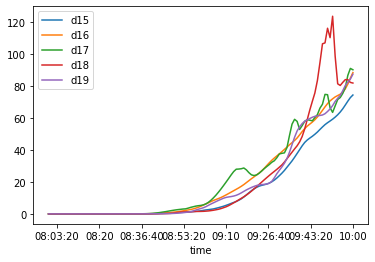

In [118]:
A['d15'].plot()
A['d16'].plot()
A['d17'].plot()
A['d18'].plot()
A['d19'].plot()
plt.legend()


In [124]:
d15n = dfghi.GHIP_SI02pt100.loc['2018-02-15 19:00:00':'2018-02-15 22:00:00']
d16n = dfghi.GHIP_SI02pt100.loc['2018-02-16 19:00:00':'2018-02-16 22:00:00']
d17n = dfghi.GHIP_SI02pt100.loc['2018-02-17 19:00:00':'2018-02-17 22:00:00']
d18n = dfghi.GHIP_SI02pt100.loc['2018-02-18 19:00:00':'2018-02-18 22:00:00']
d19n = dfghi.GHIP_SI02pt100.loc['2018-02-19 19:00:00':'2018-02-19 22:00:00']

In [125]:
d16n.index = d16n.index.time
d17n.index = d17n.index.time
d18n.index = d18n.index.time
d19n.index = d19n.index.time

In [131]:
d16n.index

Index([19:00:00, 19:01:00, 19:02:00, 19:03:00, 19:04:00, 19:05:00, 19:06:00,
       19:07:00, 19:08:00, 19:09:00,
       ...
       21:51:00, 21:52:00, 21:53:00, 21:54:00, 21:55:00, 21:56:00, 21:57:00,
       21:58:00, 21:59:00, 22:00:00],
      dtype='object', length=181)

In [134]:
noite = pd.DataFrame(index = d15n.index,  columns= ['d15n', 'd16n', 'd17n', 'd18n', 'd19n'])

In [137]:
noite.index = noite.index.time

In [141]:
noite

,d15n,d16n,d17n,d18n,d19n
19:00:00,NaN,NaN,NaN,NaN,NaN
19:01:00,NaN,NaN,NaN,NaN,NaN
19:02:00,NaN,NaN,NaN,NaN,NaN
19:03:00,NaN,NaN,NaN,NaN,NaN
19:04:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
21:56:00,NaN,NaN,NaN,NaN,NaN
21:57:00,NaN,NaN,NaN,NaN,NaN
21:58:00,NaN,NaN,NaN,NaN,NaN
21:59:00,NaN,NaN,NaN,NaN,NaN


In [142]:
noite['d15n']= d15n
noite['d16n']= d16n
noite['d17n']= d17n
noite['d18n']= d18n
noite['d19n']= d19n


In [143]:
noite

,d15n,d16n,d17n,d18n,d19n
19:00:00,NaN,171.789552,447.873333,522.231667,219.655556
19:01:00,NaN,165.714062,448.776667,471.885000,224.263636
19:02:00,NaN,160.703175,451.836667,400.115000,230.922059
19:03:00,NaN,156.486567,451.983333,645.580000,237.382540
19:04:00,NaN,153.062319,438.990000,330.028333,242.507595
...,...,...,...,...,...
21:56:00,NaN,3.140828,1.740087,2.027111,0.492282
21:57:00,NaN,2.833924,1.525571,1.791477,0.468286
21:58:00,NaN,2.502886,1.311976,1.602203,0.380045
21:59:00,NaN,2.197192,1.180838,1.430732,0.299933


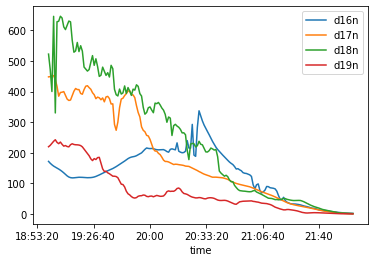

In [145]:
noite['d16n'].plot()
noite['d17n'].plot()
noite['d18n'].plot()
noite['d19n'].plot()
plt.legend()


In [146]:
d15f = dfghi.GHIP_SI02pt100.loc['2018-02-15 06:00:00':'2018-02-15 23:00:00']
d16f = dfghi.GHIP_SI02pt100.loc['2018-02-16 06:00:00':'2018-02-16 23:00:00']
d17f = dfghi.GHIP_SI02pt100.loc['2018-02-17 06:00:00':'2018-02-17 23:00:00']
d18f = dfghi.GHIP_SI02pt100.loc['2018-02-18 06:00:00':'2018-02-18 23:00:00']
d19f = dfghi.GHIP_SI02pt100.loc['2018-02-19 06:00:00':'2018-02-19 23:00:00']
d16f.index = d16f.index.time
d17f.index = d17f.index.time
d18f.index = d18f.index.time
d19f.index = d19f.index.time

In [148]:
d15f.index = d15f.index.time


In [149]:
dia = pd.DataFrame(index = d15f.index,  columns= ['d15f', 'd16f', 'd17f', 'd18f', 'd19f'])

In [151]:
dia['d15f']= d15f
dia['d16f']= d16f
dia['d17f']= d17f
dia['d18f']= d18f
dia['d19f']= d19f


In [152]:
dia

,d15f,d16f,d17f,d18f,d19f
06:00:00,-0.009516,-0.011062,-0.007613,0.001815,-0.004836
06:01:00,-0.014508,-0.000952,-0.000967,0.000000,-0.000983
06:02:00,-0.000952,0.004538,-0.016717,-0.005619,-0.001967
06:03:00,-0.011800,0.005710,-0.009833,-0.003933,0.001967
06:04:00,-0.008429,-0.001873,0.000000,-0.010817,-0.003933
...,...,...,...,...,...
22:56:00,0.000000,0.000983,-0.000983,-0.006770,-0.000983
22:57:00,0.000000,-0.000983,0.000000,-0.014508,0.000983
22:58:00,0.000000,-0.000983,0.000000,-0.014508,0.000983
22:59:00,0.000000,0.000000,0.000000,-0.013323,0.000983


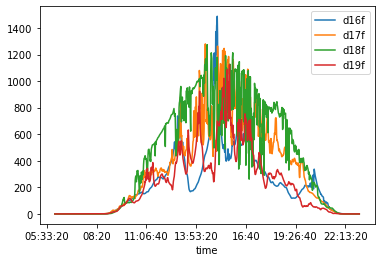

In [153]:
dia['d16f'].plot()
dia['d17f'].plot()
dia['d18f'].plot()
dia['d19f'].plot()
plt.legend()
